In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBFile, NWBHDF5IO

## First, read an example NWB 2.0 file, representing data from a single recording session

In [2]:
# Specify data path and filename
data_dir = os.path.join('..','data', 'NWB 2.0')
fname = 'mouse1_fni16_150819_150819_001_ch2-PnevPanResults-170815-163235.nwb'

In [3]:
# Read NWB 2.0 file
nwb_io = NWBHDF5IO(os.path.join(data_dir, fname), mode = 'r')
nwbfile = nwb_io.read()

## Next, we wish to extract the neuron response time-series
Here, neuron response time-series are stored as trial-segmented, time-locked to several different experimental event (e.g. *start tone*, *stimulus onset*, *choice*, or *reward*).

Thus, these neuron data takes the shape of (ROI count) x (time points) x (trial count), one set of data for each experimental event 
Since these data are trial-based segmented (as opposed to raw), they are stored in NWB 2.0 in a **processing module**, under a **data interface** of type **DfOverF**

In [4]:
# Extract all trial-based ROI time-series
# ROI time-series has the shape of: (ROI count) x (time instances) x (trial count)`
roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

The **DfOverF** data interface contains mutliple sets of trial-segmented neuron responses, each stored as a **roi_response_series**. For result figure reproduction purpose, we will extract neuron response time-series time-locked to 4 events: *initial auditory tone onset*, *stimulus onset*, *time of first commit* and *time of second commit*

Each **roi_response_series** contains a field named **rois**, which provides the indices of the ROIs in the **ROI table** specific to this **roi_response_series**

In [5]:
# Display all roi_response_series, named by the event-type that the data are time locked to
for eve in roi_series.keys():
    print(eve)

commitIncorrAl
firstSideTryAl
firstSideTryAl_COM
goToneAl
initToneAl
rewardAl
stimAl_allTrs
stimAl_noEarlyDec
stimOffAl


In [6]:
def get_trialsegmented_roi_timeseries(event_name, pre_stim_dur, post_stim_dur, roi_series):
    event_roi_timeseries = roi_series.get(event_name)
    tvec = event_roi_timeseries.timestamps
    # check if pre/post stim duration is out of bound
    pre_stim_dur = np.maximum(tvec[0], pre_stim_dur)
    post_stim_dur = np.minimum(tvec[-1], post_stim_dur)   
    # extract data
    ix = np.logical_and(tvec >= pre_stim_dur, tvec <= post_stim_dur)
    return np.array(event_roi_timeseries.data)[:, ix, :], np.array(event_roi_timeseries.timestamps)[ix]    

Neurons identification is done via a ROI segmentation routine, and the resulted segmentation information is stored under another **processing module** as **ROI-table**. Thus, each neuron (ROI) has a corresponding entry in the **ROI-table** containing ROI-related information such as: good/bad ROI, inhibitory/excitatory ROI, ROI mask, etc.

Here, we wish to extract neurons that are labeled *good* and separate neurons into categories of *excitatory* and *inhibitory*

In [7]:
# Obtain the ROI-table
# here, 'initToneAl' is selected arbitrarily, all of the roi_response_series contain the same ROI-table and good_roi_mask
roi_tcourse = roi_series.get('initToneAl')  
good_roi_mask = roi_tcourse.rois.data  # good_roi_mask here refers a 1D array of ROI indices, indexing into the ROI-table
roi_table = roi_tcourse.rois.table

In [8]:
# Visualizing the ROI-table 
roi_colums = roi_table.colnames
roi_table_df = {}
for c in roi_colums:
    if c == 'image_mask':
        continue
    roi_table_df[c] = roi_table.get(c).data if type(roi_table.get(c).data) is np.ndarray else roi_table.get(c).data.value
roi_table_df = pd.DataFrame(roi_table_df)
roi_table_df

,roi_id,roi_status,neuron_type,fitness,roi2surr_sig,offsets_ch1_pix
0,0,good,excitatory,-inf,0,-2634
1,76,good,excitatory,-inf,0,-412
2,75,good,inhibitory,-inf,3,9039
3,71,good,excitatory,-inf,0,-1672
4,68,good,excitatory,-inf,0,-1963
5,66,good,excitatory,-inf,0,-239
6,64,good,excitatory,-inf,0,-5535
7,63,good,excitatory,-inf,0,84
8,77,good,excitatory,-inf,0,146
9,62,good,excitatory,-inf,0,167


In [9]:
# Obtain inh/exc status of the ROI
neuron_type = roi_table.get('neuron_type').data[good_roi_mask]
# Display neuron_type for ease of visualization
print(neuron_type[1:20])

['excitatory' 'inhibitory' 'excitatory' 'excitatory' 'excitatory'
 'excitatory' 'excitatory' 'excitatory' 'excitatory' 'inhibitory'
 'excitatory' 'unknown' 'excitatory' 'excitatory' 'excitatory'
 'inhibitory' 'excitatory' 'excitatory' 'excitatory']


## We will now perform minor data conditioning to reproduce Figure 1E 

Again, here we seek to extract trial-segmented ROI data with respect to four events: *initial auditory tone onset*, *stimulus onset*, *time of first commit* and *time of second commit*

We also define the pre-stimulus and post-stimulus amount of time we wish to extract the data from/to

In [10]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

# extract trial-based data and average over trial
trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_roi_timeseries(setting['event'], setting['pre'], setting['post'], roi_series)
    # average
    trial_avg_segments[setting['event']] = (np.nanmean(out[0], axis=2), out[1])

In [11]:
# Function to sort the ROI time-series based on the latency of the peak activity
def roi_sort_by_peak_latency(roi_tcourse):
    sorted_roi_idx = np.argsort(np.argmax(roi_tcourse, axis = 1))
    return roi_tcourse[sorted_roi_idx,:].copy(), sorted_roi_idx

In [12]:
# Sort and concatenate trial-based data time-locked to: start tone, stimulus, 1st commit and 2nd commit

# Concatenate and sort
data_all = np.hstack((value[0] for value in trial_avg_segments.values()))
data_all, sorted_roi_idx = roi_sort_by_peak_latency(data_all)

# Concatenate all timevec(s) and determine the indices of t = 0
tvec_concat = [value[1] for value in trial_avg_segments.values()]
xdim_all = [t.size for t in tvec_concat]
xdim_all.insert(0,0)
zeros_all = [np.where(v == 0)[0][0] for v in tvec_concat]

# Extract inh/exc status
is_inh = np.zeros((data_all.shape[0]))
is_inh[neuron_type[sorted_roi_idx] == 'inhibitory'] = 1

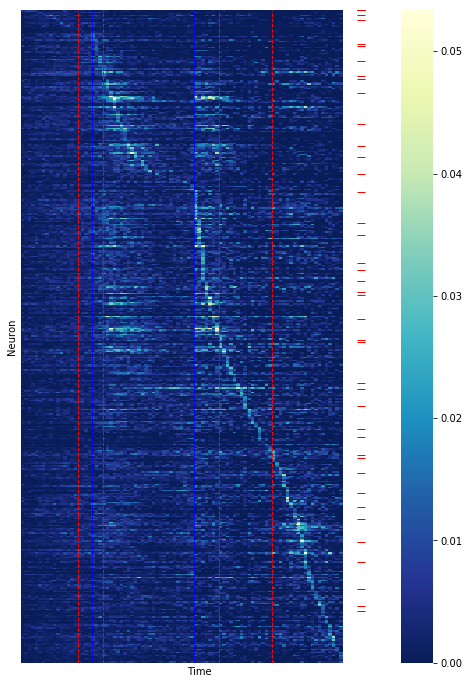

In [13]:
# Raster Plot -  Figure 1E
fig1E = plt.figure(figsize=(8,12))
ax1 = fig1E.add_subplot(111)
ax1.set_facecolor('white')

sns.heatmap(data=data_all, xticklabels=[], yticklabels=[], cmap='YlGnBu_r', axes=ax1, vmin=0)

# add vertical lines
for zidx, z in enumerate(zeros_all):
    ax1.axvline(x=np.cumsum(xdim_all)[zidx], color='b',linestyle='-',linewidth=0.7)
    ax1.axvline(x=z + np.cumsum(xdim_all)[zidx], color='r',linestyle='--',linewidth=1)
    
# add inhibitor marker
ax1.plot(np.ones(is_inh.shape)*(data_all.shape[1]+5), np.arange(is_inh.size)*is_inh, 'r_', markersize=8)

ax1.set_xlim(0, data_all.shape[1]+10)
ax1.set_xlabel('Time')
ax1.set_ylabel('Neuron')
ax1.set_label('Averaged infered spike for all neurons for an example session')

## Similarly, minor data conditioning is required for reproduction of Figure 1F 

Trial-related information is stored in NWB 2.0 under **trials**. **trials** is a table-like data structure that enforces two required variables as table columns: *start_time* and *stop_time*. User can define any number of additional table columns to store trial-specific information related to their study. 

Here, we have added 10 additional columns: *trial_type*, *trial_pulse_rate*, *trial_response*, *trial_is_good*, *init_tone*, *stim_onset*, *stim_offset*, *go_tone*, *first_commit*, *second_commit*

In [14]:
# Get trial info
trial_set = nwbfile.trials.to_dataframe()
trial_set

,start_time,stop_time,trial_type,trial_pulse_rate,trial_response,trial_is_good,init_tone,stim_onset,stim_offset,go_tone,first_commit,second_commit
id,,,,,,,,,,,,
0,31.014229,18348.166016,Low-rate,7,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
1,15.679230,10760.015625,Low-rate,6,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
2,39.345230,16673.650391,High-rate,27,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
3,34.513229,3270.759277,High-rate,26,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
4,25.180229,3811.587891,High-rate,27,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
5,22.846230,12094.043945,Low-rate,6,incorrect,True,1016.496,1100.662,2100.662,1252.828,1507.827,1645.160
6,15.681230,3705.001709,High-rate,26,correct,True,898.664,1091.496,2091.496,1297.162,1662.826,2197.492
7,22.346230,3096.779785,High-rate,27,correct,True,536.832,766.664,1766.664,1005.330,1265.496,1599.828
8,16.013229,13446.433594,Low-rate,7,incorrect,True,1526.494,1716.993,2716.993,1907.659,2170.824,2987.321


For the reproduction of Figure 1F, we wish to extract neuronal responses of *excitatory* and *inhibitory* neurons, separated by *trial type* category of either *High Rate* or *Low Rate*, and constrained by the condition that the mouse's response for this trial is correct

In [15]:
trial_is_good = trial_set.trial_is_good
trial_response_type = trial_set.trial_response
trial_type = trial_set.trial_type

In [16]:
# make trial-mask for correct high-rate (ipsilateral-lick) and low-rate (contralateral-lick) trial
correct_high_rate_trial = np.logical_and(trial_response_type == 'correct', trial_type == 'High-rate')
correct_low_rate_trial = np.logical_and(trial_response_type == 'correct', trial_type == 'Low-rate')

In [17]:
# make mask of inhibitory and excitatory neuron
is_inh = (neuron_type == 'inhibitory')
is_exc = (neuron_type == 'excitatory')

In [18]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_roi_timeseries(setting['event'], setting['pre'], setting['post'], roi_series)
    # mask by high/low rate trial and inh/exc neuron type
    exc_correct_hr = out[0][:,:,correct_high_rate_trial][is_exc,:,:]
    inh_correct_hr = out[0][:,:,correct_high_rate_trial][is_inh,:,:]
    exc_correct_lr = out[0][:,:,correct_low_rate_trial][is_exc,:,:]
    inh_correct_lr = out[0][:,:,correct_low_rate_trial][is_inh,:,:]
    # take average across trials
    trial_avg_segments[setting['event']] = {'exc_correct_hr':np.nanmean(exc_correct_hr, axis=2),
                                            'inh_correct_hr':np.nanmean(inh_correct_hr, axis=2),
                                            'exc_correct_lr':np.nanmean(exc_correct_lr, axis=2),
                                            'inh_correct_lr':np.nanmean(inh_correct_lr, axis=2),
                                            'timestamps':out[1]}

In [19]:
# plot a single subplot of Figure 1F
def plot_sub_fig1F(exc_ax, inh_ax, trial_avg_segments, exc_idx, inh_idx):    
  
    # make a nan-padding between each dataset 
    pad_size = 3
    nan_padding = np.full(pad_size, np.nan)
    
    # Concatenate and add nan padding in between    
    r = {k: np.hstack(np.hstack((v[k][idx,:], nan_padding)) for v in trial_avg_segments.values()) 
                       for k, idx in (('exc_correct_hr', exc_idx),
                                      ('inh_correct_hr', inh_idx),
                                      ('exc_correct_lr', exc_idx),
                                      ('inh_correct_lr', inh_idx))}    
    tvec = np.hstack(np.hstack((v['timestamps'], nan_padding)) for v in trial_avg_segments.values())      
    
    # determine the indices of t = 0
    t_zeros = np.where(tvec == 0)[0]

    for ax, roi_key in ((exc_ax, ('exc_correct_lr', 'exc_correct_hr')),  (inh_ax, ('inh_correct_lr', 'inh_correct_hr'))):
            ax.plot(r[roi_key[0]], 'k', alpha=0.6) 
            ax.plot(r[roi_key[1]], 'g', alpha=0.8)   
            # add vertical lines
            for t in t_zeros:
                ax.axvline(x=t, color='k', linestyle='--', linewidth=0.7)
                ax.set_facecolor('w')
                ax.set_xticklabels([])
                ax.set_title(roi_key[0].split('_')[0])

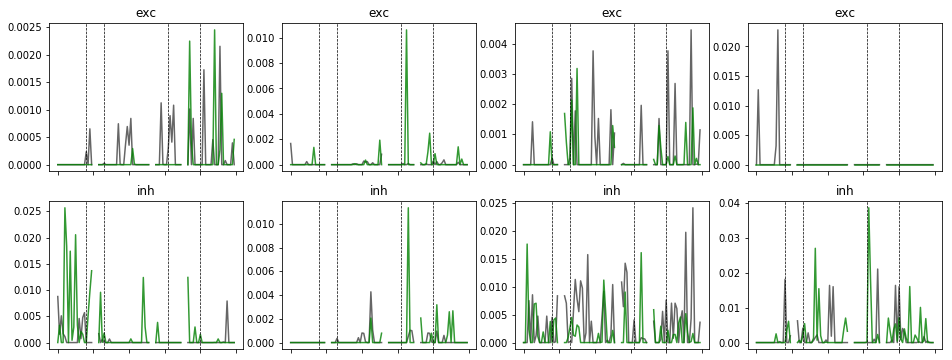

In [20]:
# Plot figure 1F
fig1F, axes = plt.subplots(2, 4, figsize=(16,6))
for a, e, i in zip(axes.T, [5, 11, 22, 25], [5, 6, 7, 22]):
    plot_sub_fig1F(a[0], a[1], trial_avg_segments, e, i)

In [21]:
nwb_io.close()

## Reproducion of Figure 1H 

From all session, obtain neuron inferred spike activity (average of 3-frames before choice) for inhibitory and excitatory neurons.

Since each NWB 2.0 represent data from a single recording session, we will iterate through all session and extract the mean spiking response in ~100 ms prior to the time of *first commit* (*choice*-event) for all *inhibitory* and *excitatory* neurons 

In [22]:
def extract_all_roi_timeseries():
    choice_event_key = 'firstSideTryAl'
    pre_dur = -97
    post_dur = 0
    for f in os.listdir(data_dir):
        # Read NWB 2.0 file
        nwb_io = NWBHDF5IO(os.path.join(data_dir, f), mode = 'r')
        nwbfile = nwb_io.read()

        roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

        # Obtain inh/exc status of the ROI
        roi_tcourse = roi_series.get(choice_event_key)
        good_roi_mask = roi_tcourse.rois.data
        roi_table = roi_tcourse.rois.table
        neuron_type = roi_table.get('neuron_type').data[good_roi_mask]

        roi_ts, _ = get_trialsegmented_roi_timeseries(choice_event_key, pre_dur, post_dur, roi_series)
        
        nwb_io.close()

        # average over timepoints
        yield {'inh_rois': np.nanmean(roi_ts[neuron_type == 'inhibitory', :, :], axis=1),
               'exc_rois': np.nanmean(roi_ts[neuron_type == 'excitatory', :, :], axis=1),
               'inh_count': roi_ts[neuron_type == 'inhibitory', :, :].shape[0],
               'exc_count': roi_ts[neuron_type == 'excitatory', :, :].shape[0]}    

In [23]:
avg_inh_rois, avg_exc_rois, inh_counts, exc_counts = zip(*((r['inh_rois'], 
                                                            r['exc_rois'],
                                                            r['inh_count'],
                                                            r['exc_count']) 
                                                           for r in extract_all_roi_timeseries()))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [24]:
# average over trial
avg_exc_rois = np.hstack(np.nanmean(r, axis=1) for r in avg_exc_rois)
avg_inh_rois = np.hstack(np.nanmean(r, axis=1) for r in avg_inh_rois)

Excitatory neurons: 44546 - Inhibitory neurons: 5530


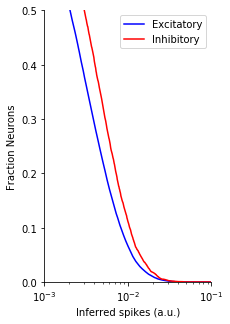

In [25]:
# process and plot Figure 1H
spike_val_vec = np.logspace(-3, 0, 1000)
exc_roi_frac = np.sum(avg_exc_rois[:, None] > spike_val_vec, axis=0) / len(avg_exc_rois)
inh_roi_frac = np.sum(avg_inh_rois[:, None] > spike_val_vec, axis=0) / len(avg_inh_rois)

print(f'Excitatory neurons: {sum(exc_counts)} - Inhibitory neurons: {sum(inh_counts)}')
fig1H, ax = plt.subplots(1, 1, figsize=(3, 5))
ax.semilogx(spike_val_vec, exc_roi_frac, 'b', label='Excitatory')
ax.semilogx(spike_val_vec, inh_roi_frac, 'r', label='Inhibitory')
ax.legend()
ax.set_ylabel('Fraction Neurons')
ax.set_xlabel('Inferred spikes (a.u.)')
ax.set_xlim(1e-3, 1e-1)
ax.set_ylim(0, 0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [26]:
# exc and inh roi count for each session
df = pd.DataFrame([(f for f in os.listdir(data_dir)), exc_counts, inh_counts]).T
df.columns = ['session', 'exc_count', 'inh_count']
print(f'Average ROI count across sessions - Exc: {df.exc_count.mean()} - Inh: {df.inh_count.mean()}')
df

Average ROI count across sessions - Exc: 329.97037037037035 - Inh: 40.96296296296296


,session,exc_count,inh_count
0,mouse1_fni16_150817_150817_001_ch2-PnevPanResu...,280,38
1,mouse1_fni16_150818_150818_001_ch2-PnevPanResu...,264,42
2,mouse1_fni16_150819_150819_001_ch2-PnevPanResu...,305,39
3,mouse1_fni16_150820_150820_001_ch2-PnevPanResu...,341,49
4,mouse1_fni16_150821_150821_001-002_ch2-PnevPan...,342,48
5,mouse1_fni16_150825_150825_001-002-003_ch2-Pne...,363,51
6,mouse1_fni16_150826_150826_001_ch2-PnevPanResu...,284,44
7,mouse1_fni16_150827_150827_001_ch2-PnevPanResu...,340,46
8,mouse1_fni16_150828_150828_001-002_ch2-PnevPan...,333,50
9,mouse1_fni16_150831_150831_001-002_ch2-PnevPan...,385,48
